#### Importing Modules and setting Random seed

In [1]:
import os
import torch
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
rand_seed = np.random.seed(1207) # set random seed for reproducibility
from keras.datasets import mnist
from torchvision import datasets
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from torchvision.transforms import ToTensor
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
tsne = TSNE(n_components=2, random_state=rand_seed, perplexity=1)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Fashion MNIST dataset labels
fashion_mnist_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt','Sneaker', 'Bag', 'Ankle boot']

# GPU settings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}')

# Checking for figures directory
if not os.path.exists('figures'):
    os.makedirs('figures')

Using cuda


#### Downloading and Caching the MNIST and FashionMNIST dataset

In [3]:
# Create a directory to store the dataset
if not os.path.exists(os.path.join(os.getcwd(), "dataset/MNIST")):
    os.makedirs(os.path.join(os.getcwd(), "dataset/MNIST"))

dataset_path = os.path.join(os.getcwd(), "dataset/MNIST/mnist.npz")

#download the mnist dataset and cache it in current directory
(x_train, y_train), (x_test, y_test) = mnist.load_data(path=dataset_path)

# Dowload train data of fashionmnist from torchvision datasets
training_data = datasets.FashionMNIST(root='dataset', train=True, download=True, transform=ToTensor())
x_train_fm = training_data.data
y_train_fm = training_data.targets

# Dowload test data of fashionmnist from torchvision datasets
test_data = datasets.FashionMNIST(root='dataset', train=False, download=True, transform=ToTensor())
x_test_fm = test_data.data
y_test_fm = test_data.targets

#### Displaying the Shapes of the Training and Testing Datasets of MNIST and Fashion MNIST

In [4]:
print("MNIST dataset Details")
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

print("\nFashion MNIST dataset Details")
print("x_train_fm shape: ", x_train_fm.shape)
print("y_train_fm shape: ", y_train_fm.shape)
print("x_test_fm shape: ", x_test_fm.shape)
print("y_test_fm shape: ", y_test_fm.shape)

MNIST dataset Details
x_train shape:  (60000, 28, 28)
y_train shape:  (60000,)
x_test shape:  (10000, 28, 28)
y_test shape:  (10000,)

Fashion MNIST dataset Details
x_train_fm shape:  torch.Size([60000, 28, 28])
y_train_fm shape:  torch.Size([60000])
x_test_fm shape:  torch.Size([10000, 28, 28])
y_test_fm shape:  torch.Size([10000])


#### Getting 10 Unique Samples from the MNIST and FashionMNIST Datasets

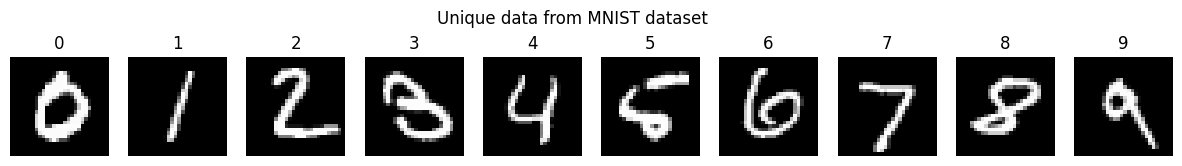

In [5]:
unique_data = []
unique_label = []
for i in range(10):
    idx = np.where(y_test == i)[0][0]
    unique_data.append(x_test[idx])
    unique_label.append(y_test[idx])

# Plot the unique data
fig, ax = plt.subplots(1, 10, figsize=(15, 2))
fig.suptitle('Unique data from MNIST dataset')
z = iter(range(10))
for i in range(10):
    ax[i].imshow(unique_data[i], cmap='gray')
    ax[i].set_title(z.__next__())
    ax[i].axis('off')
plt.savefig('./figures/unique_data.pdf', bbox_inches='tight')
plt.show()

# Creating the dataloaders for the unique data
unique_data = torch.tensor(unique_data, dtype=torch.float32)
unique_label = torch.tensor(unique_label, dtype=torch.long)
test_dataset_unique = TensorDataset(unique_data, unique_label)
test_loader_unique = DataLoader(test_dataset_unique, batch_size=1, shuffle=False)

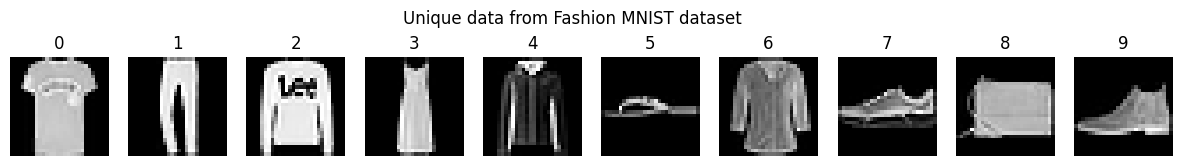

In [6]:
unique_data_fm = []
unique_label_fm = []
y_test_fm = y_test_fm.numpy()
x_test_fm = x_test_fm.numpy()

for i in range(10):
    idx = np.where(y_test_fm == i)[0][0]
    unique_data_fm.append(x_test_fm[idx])
    unique_label_fm.append(y_test_fm[idx])

# Plot the unique data
fig, ax = plt.subplots(1, 10, figsize=(15, 2))
fig.suptitle('Unique data from Fashion MNIST dataset')
z = iter(range(10))
for i in range(10):
    ax[i].imshow(unique_data_fm[i], cmap='gray')
    ax[i].set_title(z.__next__())
    ax[i].axis('off')
plt.savefig('./figures/unique_data_fm.pdf', bbox_inches='tight')
plt.show()

# Creating the dataloaders for the unique data
unique_data_fm = torch.tensor(unique_data_fm, dtype=torch.float32)
unique_label_fm = torch.tensor(unique_label_fm, dtype=torch.long)
test_dataset_unique_fm = TensorDataset(unique_data_fm, unique_label_fm)
test_loader_unique_fm = DataLoader(test_dataset_unique_fm, batch_size=1, shuffle=False)

#### Printing few samples from the Testing dataset

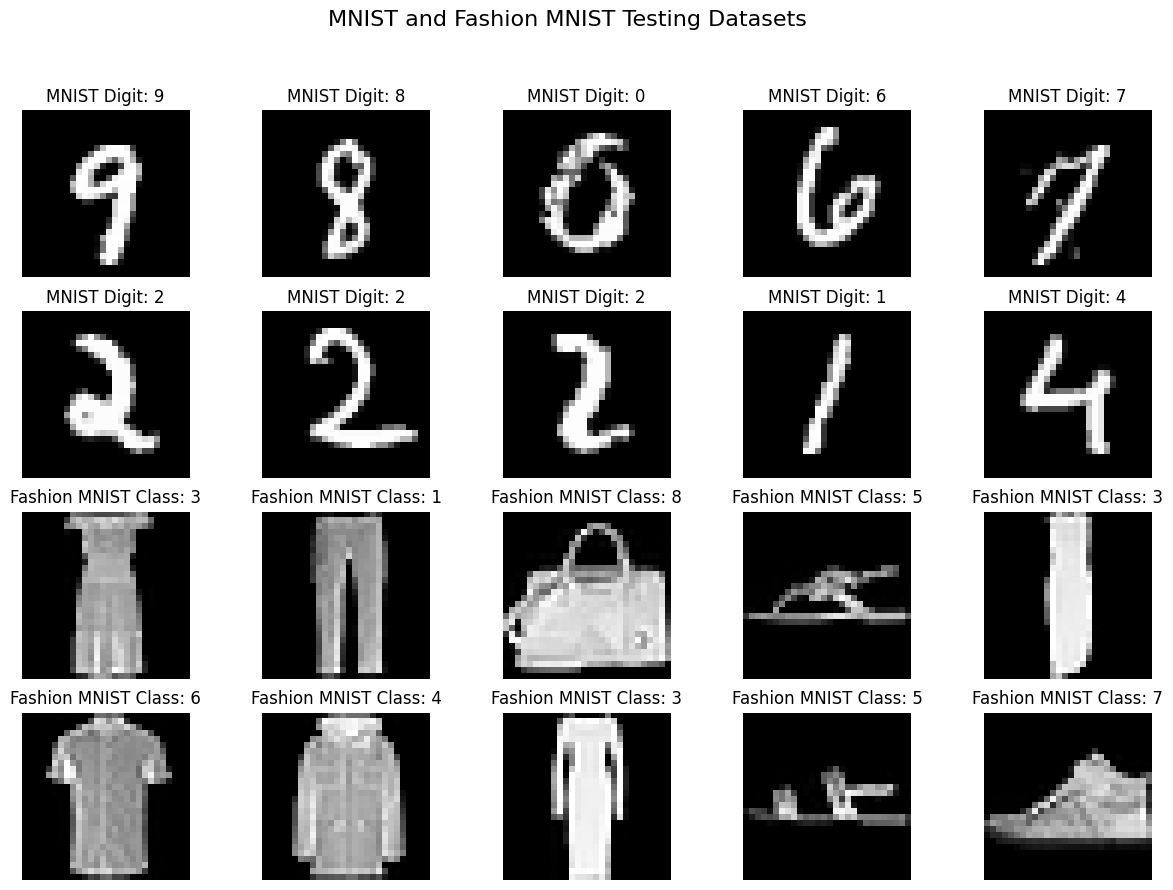

In [7]:
fig, ax = plt.subplots(4, 5, figsize=(15, 10))
fig.suptitle("MNIST and Fashion MNIST Testing Datasets", fontsize=16)

# Plot the MNIST dataset
for i in range(2):
    for j in range(5):
        rand = np.random.randint(0, x_test.shape[0])
        ax[i, j].imshow(x_test[rand, :, :], cmap='gray')
        ax[i, j].set_title("MNIST Digit: {}".format(y_test[rand]))
        ax[i, j].axis('off')

# Plot the Fashion MNIST dataset
for i in range(2, 4):
    for j in range(5):
        rand = np.random.randint(0, x_test_fm.shape[0])
        ax[i, j].imshow(x_test_fm[rand, :, :], cmap='gray')
        ax[i, j].set_title("Fashion MNIST Class: {}".format(y_test_fm[rand]))
        ax[i, j].axis('off')

plt.savefig('./figures/mnist_fashionmnist.pdf', bbox_inches='tight')
plt.show()

#### Training A Random Forest Model on the MNIST dataset

Accuracy of the RF model on the 10000 test images: 0.9699
F1 Score of the RF model on the 10000 test images: 0.9696461912093433


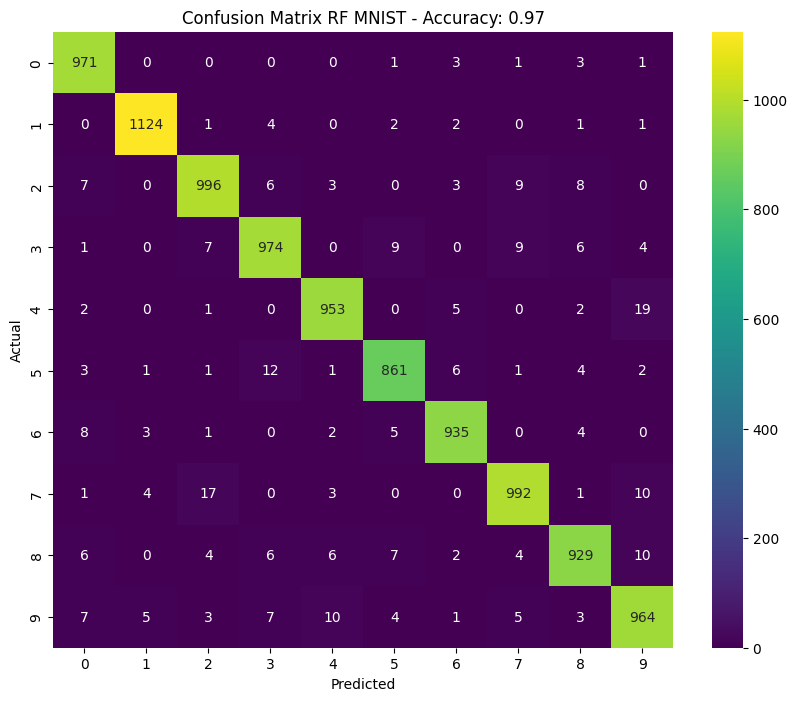

In [8]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=rand_seed)
random_forest.fit(x_train.reshape(-1, 28*28), y_train)
y_pred = random_forest.predict(x_test.reshape(-1, 28*28))

print(f"Accuracy of the RF model on the 10000 test images: {accuracy_score(y_test, y_pred)}")
print(f"F1 Score of the RF model on the 10000 test images: {f1_score(y_test, y_pred, average='macro')}")

# Plottiing the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix RF MNIST - Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
plt.xticks(np.arange(10) + 0.5, np.arange(10))
plt.yticks(np.arange(10) + 0.5, np.arange(10))
plt.savefig('./figures/confusion_matrix_rf_mnist.pdf', bbox_inches='tight')
plt.show()

#### The confusion on the digits from the confusion matrix of RF Model for the MNIST dataset

In [9]:
# Initialize an empty list to store the results
results = []

# Loop over the confusion matrix
for i in range(10):
  for j in range(10):
    if i != j and cm[i, j] > 8:
      # Append the count and the corresponding labels to the results list
      results.append((cm[i, j], i, j))

# Sort the results in descending order based on the count
results.sort(key=lambda x: x[0], reverse=True)

# Print the sorted results
for count, i, j in results:
  print(f"RF Model confused {count} times between {i} and {j}")

RF Model confused 19 times between 4 and 9
RF Model confused 17 times between 7 and 2
RF Model confused 12 times between 5 and 3
RF Model confused 10 times between 7 and 9
RF Model confused 10 times between 8 and 9
RF Model confused 10 times between 9 and 4
RF Model confused 9 times between 2 and 7
RF Model confused 9 times between 3 and 5
RF Model confused 9 times between 3 and 7


#### Creating Train, Test and Validation DataLoaders for the MNIST dataset

In [10]:
# Flattening the images
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

# Splitting the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=rand_seed)

# Converting the numpy arrays to torch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

x_train, y_train = x_train.to(device), y_train.to(device)
x_val, y_val = x_val.to(device), y_val.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

# Creating a dataloader for the training and validation sets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2048, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)

#### Training A Logistic Regression Model on the MNIST dataset

In [11]:
# Define the logistic regression model

class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        # this one 
        # "logits" refers to the raw output of the last layer of a neural network before applying an activation function 
        out = self.linear(x)
        # out = torch.sigmoid(self.linear(x))
        return out
    
# Create the model
input_size = 784
num_classes = 10
model = LogisticRegression(input_size, num_classes).to(device)

# Define the loss function and optimizer
# CrossEntropyLoss expects the raw scores (logits) from the model.
# PyTorch combines both a softmax operation and the negative log likelihood loss in one class. 
# This is why you didn't apply softmax in the model's forward method; 

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Adding L2 regularization

# Traininig the model and calculate the loss
n_epochs = 100

train_losses = []
val_losses = []

for epoch in range(n_epochs):
        
    train_loss = 0.0
    val_loss = 0.0
    model.train()  # Set model to training mode
    for inputs, labels in train_loader:
        
        #  clears old gradients from the last step    
        optimizer.zero_grad()
        # Reshape inputs if your model requires flattened inputs, otherwise comment the next line
        inputs = inputs.reshape(-1, 784)  # Assuming 28x28 images for a total of 784 pixels
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        # updates the model parameters based on the gradients 
        # computed in the backward() method.
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, labels in val_loader:
            # Reshape inputs if your model requires flattened inputs, otherwise comment the next line
            inputs = inputs.reshape(-1, 784)  # Adjust this line if your input size is different
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
    
    print(f"Epoch: {epoch+1} Training Loss: {train_loss:.6f} Validation Loss: {val_loss:.6f}")

Epoch: 1 Training Loss: 18.452221 Validation Loss: 5.530814
Epoch: 2 Training Loss: 4.795968 Validation Loss: 3.644686
Epoch: 3 Training Loss: 3.410512 Validation Loss: 2.987082
Epoch: 4 Training Loss: 2.749322 Validation Loss: 2.624436
Epoch: 5 Training Loss: 2.338330 Validation Loss: 2.420667
Epoch: 6 Training Loss: 2.059030 Validation Loss: 2.225636
Epoch: 7 Training Loss: 1.841983 Validation Loss: 2.047765
Epoch: 8 Training Loss: 1.668746 Validation Loss: 1.952427
Epoch: 9 Training Loss: 1.531594 Validation Loss: 1.819246
Epoch: 10 Training Loss: 1.414485 Validation Loss: 1.732317
Epoch: 11 Training Loss: 1.316999 Validation Loss: 1.610900
Epoch: 12 Training Loss: 1.214977 Validation Loss: 1.525228
Epoch: 13 Training Loss: 1.135006 Validation Loss: 1.524599
Epoch: 14 Training Loss: 1.092309 Validation Loss: 1.363911
Epoch: 15 Training Loss: 1.038517 Validation Loss: 1.432077
Epoch: 16 Training Loss: 0.975275 Validation Loss: 1.363738
Epoch: 17 Training Loss: 0.929268 Validation Los

#### Plotting the confusion matrix for the Logistic Regression model

Accuracy of the LR model on the 10000 test images: 0.8894
F1 Score of the LR model on the 10000 test images: 0.8878625436577732


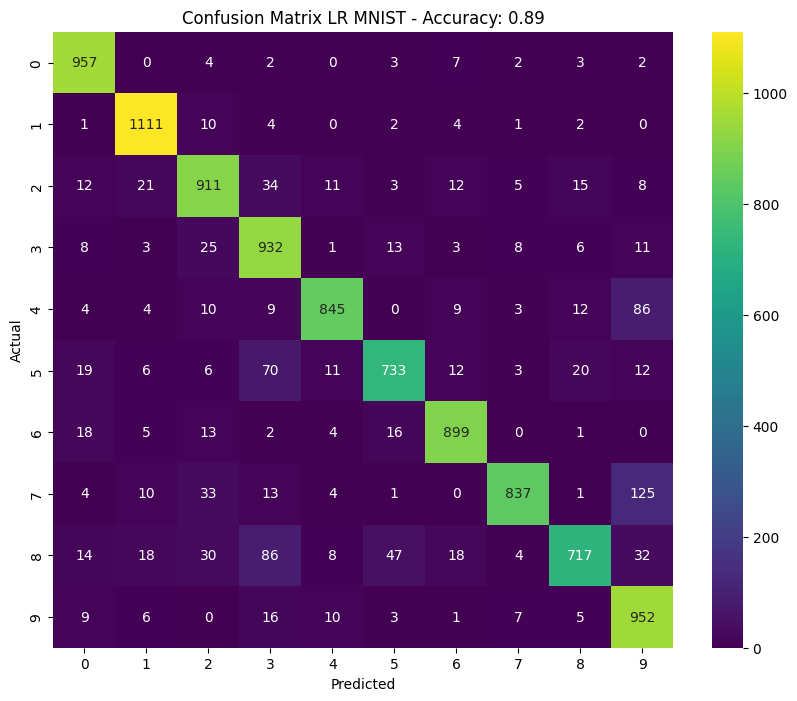

In [12]:
with torch.no_grad():
    y_pred = []
    y_true = []
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.tolist())
        y_true.extend(labels.tolist())

print(f"Accuracy of the LR model on the 10000 test images: {accuracy_score(y_true, y_pred)}")
print(f"F1 Score of the LR model on the 10000 test images: {f1_score(y_true, y_pred, average='macro')}")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix LR MNIST - Accuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
plt.xticks(np.arange(10) + 0.5, np.arange(10))
plt.yticks(np.arange(10) + 0.5, np.arange(10))
plt.savefig('./figures/confusion_matrix_lr_mnist.pdf', bbox_inches='tight')
plt.show()

#### Plotting the training and validation losses of the Logistic Regression model

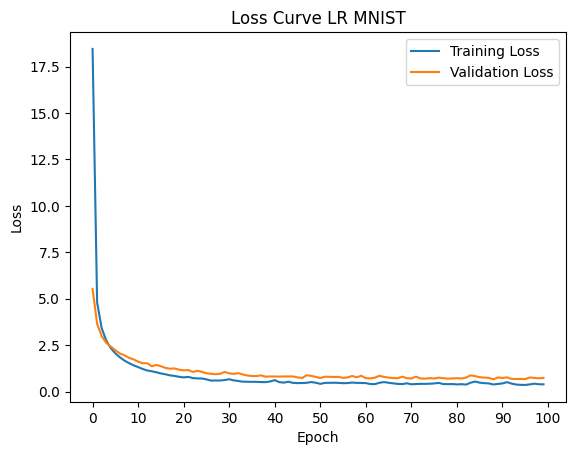

In [13]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(0, n_epochs+1, 10))
plt.title('Loss Curve LR MNIST')
plt.legend()
plt.savefig('./figures/loss_curve_lr_mnist.pdf', bbox_inches='tight')
plt.show()

#### The confusion on the digits from the confusion matrix of LR Model for the MNIST dataset

In [14]:
# Initialize an empty list to store the results
results = []

# Loop over the confusion matrix
for i in range(10):
  for j in range(10):
    if i != j and cm[i, j] > 8:
      # Append the count and the corresponding labels to the results list
      results.append((cm[i, j], i, j))

# Sort the results in descending order based on the count
results.sort(key=lambda x: x[0], reverse=True)

# Print the sorted results
for count, i, j in results:
  print(f"LR Model confused {count} times between {i} and {j}")

LR Model confused 125 times between 7 and 9
LR Model confused 86 times between 4 and 9
LR Model confused 86 times between 8 and 3
LR Model confused 70 times between 5 and 3
LR Model confused 47 times between 8 and 5
LR Model confused 34 times between 2 and 3
LR Model confused 33 times between 7 and 2
LR Model confused 32 times between 8 and 9
LR Model confused 30 times between 8 and 2
LR Model confused 25 times between 3 and 2
LR Model confused 21 times between 2 and 1
LR Model confused 20 times between 5 and 8
LR Model confused 19 times between 5 and 0
LR Model confused 18 times between 6 and 0
LR Model confused 18 times between 8 and 1
LR Model confused 18 times between 8 and 6
LR Model confused 16 times between 6 and 5
LR Model confused 16 times between 9 and 3
LR Model confused 15 times between 2 and 8
LR Model confused 14 times between 8 and 0
LR Model confused 13 times between 3 and 5
LR Model confused 13 times between 6 and 2
LR Model confused 13 times between 7 and 3
LR Model c

#### Defining A MLP Model on the MNIST dataset

In [15]:
# Defining the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 30)
        self.fc2 = nn.Linear(30, 20)
        self.fc3 = nn.Linear(20, 10)

    def forward(self, x, return_features=False):
        x = F.relu(self.fc1(x))
        if return_features:
            return F.relu(self.fc2(x)).squeeze()
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# Creating the model, loss function and optimizer
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Get the output of the second layer for all digits from the Untrained MLP model

In [16]:
# Get the output of the second layer for untrained model
features_untrained = []
with torch.no_grad():
    for x, y in test_loader_unique:
        x, y = x.to(device), y.to(device)
        feature = model(x.view(-1, 784), return_features=True)
        features_untrained.append(feature.cpu().numpy())

#### Training the model

In [17]:
n_epochs = 25
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    train_loss = 0.0
    val_loss = 0.0
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    with torch.no_grad():
        model.eval()
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
    
    print("Epoch: {} Training Loss: {:.6f} Validation Loss: {:.6f}".format(epoch+1, train_loss, val_loss))

Epoch: 1 Training Loss: 2.870386 Validation Loss: 1.264812
Epoch: 2 Training Loss: 1.007222 Validation Loss: 0.769753
Epoch: 3 Training Loss: 0.682798 Validation Loss: 0.571123
Epoch: 4 Training Loss: 0.527681 Validation Loss: 0.464501
Epoch: 5 Training Loss: 0.437512 Validation Loss: 0.399132
Epoch: 6 Training Loss: 0.376378 Validation Loss: 0.361975
Epoch: 7 Training Loss: 0.335372 Validation Loss: 0.331310
Epoch: 8 Training Loss: 0.304584 Validation Loss: 0.309806
Epoch: 9 Training Loss: 0.278544 Validation Loss: 0.290350
Epoch: 10 Training Loss: 0.258361 Validation Loss: 0.281010
Epoch: 11 Training Loss: 0.241588 Validation Loss: 0.266146
Epoch: 12 Training Loss: 0.228069 Validation Loss: 0.259956
Epoch: 13 Training Loss: 0.217495 Validation Loss: 0.254477
Epoch: 14 Training Loss: 0.207993 Validation Loss: 0.251049
Epoch: 15 Training Loss: 0.200250 Validation Loss: 0.243461
Epoch: 16 Training Loss: 0.190848 Validation Loss: 0.237826
Epoch: 17 Training Loss: 0.183175 Validation Loss

#### Plotting the training and validation losses of the MLP model

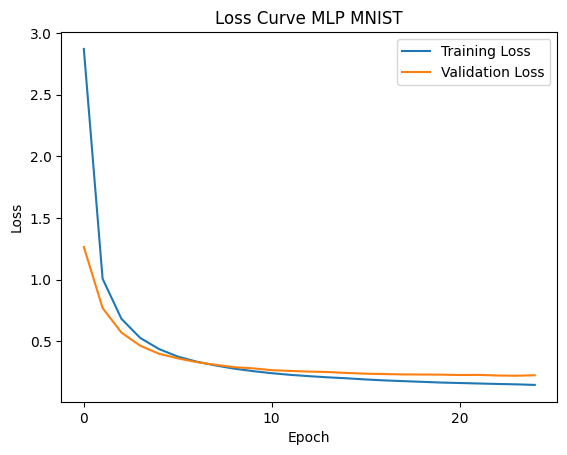

In [18]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve MLP MNIST')
plt.xticks(range(0, n_epochs+1, 10))
plt.legend()
plt.savefig('./figures/loss_curve_mlp_mnist.pdf', bbox_inches='tight')
plt.show()

#### Plotting the confusion matrix for the MLP model

Accuracy of the MLP model on the 10000 test images: 0.9409
F1 Score of the MLP model on the 10000 test images: 0.9401109816007314


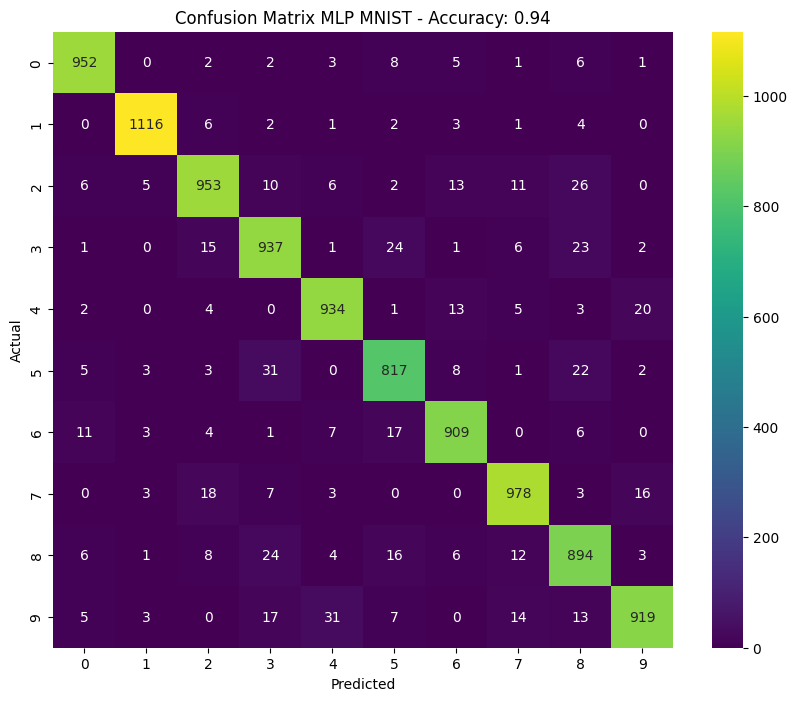

In [19]:
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.tolist())
        y_true.extend(labels.tolist())

print(f"Accuracy of the MLP model on the 10000 test images: {accuracy_score(y_true, y_pred)}")
print(f"F1 Score of the MLP model on the 10000 test images: {f1_score(y_true, y_pred, average='macro')}")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix MLP MNIST - Accuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
plt.xticks(np.arange(10) + 0.5, np.arange(10))
plt.yticks(np.arange(10) + 0.5, np.arange(10))
plt.savefig('./figures/confusion_matrix_mlp_mnist.pdf', bbox_inches='tight')
plt.show()

#### The confusion on the digits from the confusion matrix of MLP Model for the MNIST dataset

In [20]:
# Initialize an empty list to store the results
results = []

# Loop over the confusion matrix
for i in range(10):
  for j in range(10):
    if i != j and cm[i, j] > 8:
      # Append the count and the corresponding labels to the results list
      results.append((cm[i, j], i, j))

# Sort the results in descending order based on the count
results.sort(key=lambda x: x[0], reverse=True)

# Print the sorted results
for count, i, j in results:
  print(f"MLP Model confused {count} times between {i} and {j}")

MLP Model confused 31 times between 5 and 3
MLP Model confused 31 times between 9 and 4
MLP Model confused 26 times between 2 and 8
MLP Model confused 24 times between 3 and 5
MLP Model confused 24 times between 8 and 3
MLP Model confused 23 times between 3 and 8
MLP Model confused 22 times between 5 and 8
MLP Model confused 20 times between 4 and 9
MLP Model confused 18 times between 7 and 2
MLP Model confused 17 times between 6 and 5
MLP Model confused 17 times between 9 and 3
MLP Model confused 16 times between 7 and 9
MLP Model confused 16 times between 8 and 5
MLP Model confused 15 times between 3 and 2
MLP Model confused 14 times between 9 and 7
MLP Model confused 13 times between 2 and 6
MLP Model confused 13 times between 4 and 6
MLP Model confused 13 times between 9 and 8
MLP Model confused 12 times between 8 and 7
MLP Model confused 11 times between 2 and 7
MLP Model confused 11 times between 6 and 0
MLP Model confused 10 times between 2 and 3


#### Predicting on the FashionMNIST dataset using the trained MLP model on MNIST dataset

In [21]:
# Creating a dataloader for the training and validation sets
x_train_fm = x_train_fm.reshape(x_train_fm.shape[0], -1)
x_test_fm = x_test_fm.reshape(x_test_fm.shape[0], -1)
x_train_fm = torch.tensor(x_train_fm, dtype=torch.float32)
y_train_fm = torch.tensor(y_train_fm, dtype=torch.long)
x_test_fm = torch.tensor(x_test_fm, dtype=torch.float32)
y_test_fm = torch.tensor(y_test_fm, dtype=torch.long)
x_train_fm, y_train_fm = x_train_fm.to(device), y_train_fm.to(device)
x_test_fm, y_test_fm = x_test_fm.to(device), y_test_fm.to(device)

train_dataset_fm = TensorDataset(x_train_fm, y_train_fm)
test_dataset_fm = TensorDataset(x_test_fm, y_test_fm)

train_loader_fm = DataLoader(train_dataset_fm, batch_size=2048, shuffle=True)
test_loader_fm = DataLoader(test_dataset_fm, batch_size=2048, shuffle=False)

Accuracy of the MLP model on the 10000 test images: 0.129
F1 Score of the MLP model on the 10000 test images: 0.08775646728144473


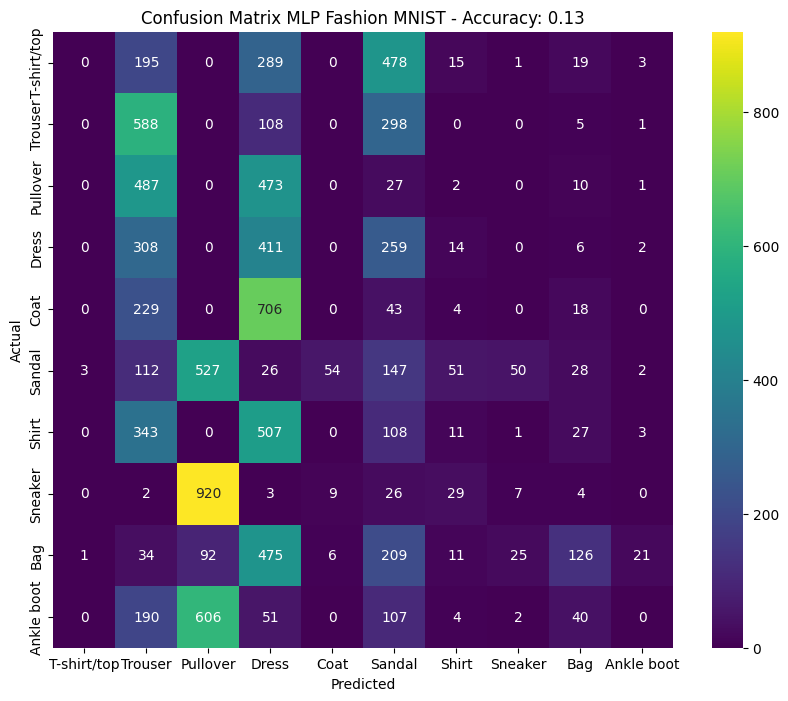

In [22]:
model.eval()
y_pred_fm = []
y_true_fm = []

with torch.no_grad():
   for inputs, labels in test_loader_fm:
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    y_pred_fm.extend(preds.tolist())
    y_true_fm.extend(labels.tolist())

print(f"Accuracy of the MLP model on the 10000 test images: {accuracy_score(y_true_fm, y_pred_fm)}")
print(f"F1 Score of the MLP model on the 10000 test images: {f1_score(y_true_fm, y_pred_fm, average='macro')}")

cm = confusion_matrix(y_true_fm, y_pred_fm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix MLP Fashion MNIST - Accuracy: {:.2f}'.format(accuracy_score(y_true_fm, y_pred_fm)))
plt.xticks(np.arange(10) + 0.5, fashion_mnist_labels)
plt.yticks(np.arange(10) + 0.5, fashion_mnist_labels)
plt.savefig('./figures/confusion_matrix_mlp_fashionmnist.pdf', bbox_inches='tight')
plt.show()

#### Get the output of second layer for all digits from the Trained MLP model for MNIST and FashionMNIST dataset

In [23]:
features_trained = []
with torch.no_grad():
    for x, y in test_loader_unique:
        x, y = x.to(device), y.to(device)
        feature = model(x.view(-1, 784), return_features=True)
        features_trained.append(feature.cpu().numpy())

In [24]:
features_trained_fm = []
with torch.no_grad():
    for x, y in test_loader_unique_fm:
        x, y = x.to(device), y.to(device)
        feature = model(x.view(-1, 784), return_features=True)
        features_trained_fm.append(feature.cpu().numpy())

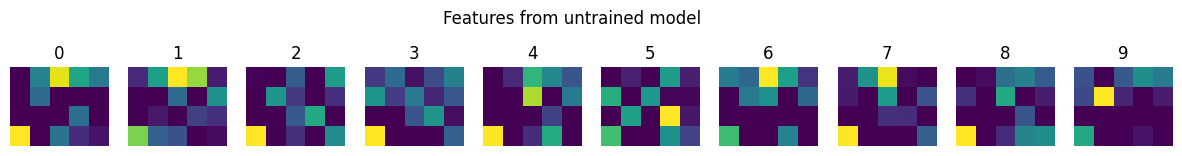

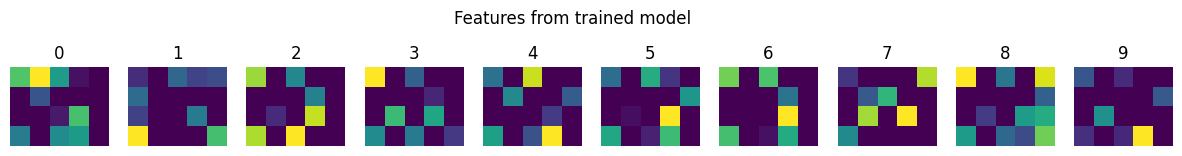

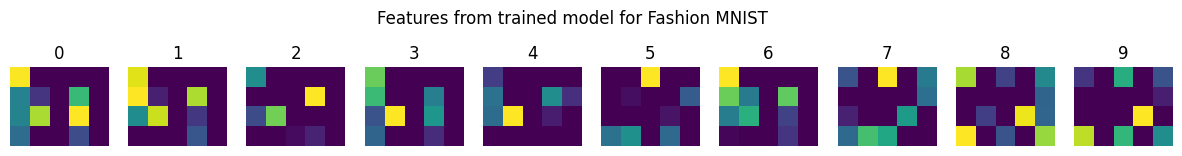

In [25]:
# Plot the untrained model's features
fig, ax = plt.subplots(1, 10, figsize=(15, 2))
fig.suptitle('Features from untrained model')
z = iter(range(10))
for i in range(10):
    ax[i].imshow(features_untrained[i].reshape(4, 5), cmap='viridis')
    ax[i].set_title(z.__next__())
    ax[i].axis('off')
plt.savefig('./figures/features_untrained_mlp.pdf', bbox_inches='tight')
plt.show()

# Plot the trained model's features
fig, ax = plt.subplots(1, 10, figsize=(15, 2))
fig.suptitle('Features from trained model')
z = iter(range(10))
for i in range(10):
    ax[i].imshow(features_trained[i].reshape(4, 5), cmap='viridis')
    ax[i].set_title(z.__next__())
    ax[i].axis('off')
plt.savefig('./figures/features_trained_mlp.pdf', bbox_inches='tight')
plt.show()

# Plot the trained model's features for Fashion MNIST
fig, ax = plt.subplots(1, 10, figsize=(15, 2))
fig.suptitle('Features from trained model for Fashion MNIST')
z = iter(range(10))
for i in range(10):
    ax[i].imshow(features_trained_fm[i].reshape(4, 5), cmap='viridis')
    ax[i].set_title(z.__next__())
    ax[i].axis('off')
plt.savefig('./figures/features_trained_mlp_fm.pdf', bbox_inches='tight')
plt.show()

#### Plotting the t-SNE plot for the output of the second layer of the Untrained and Trained MLP model

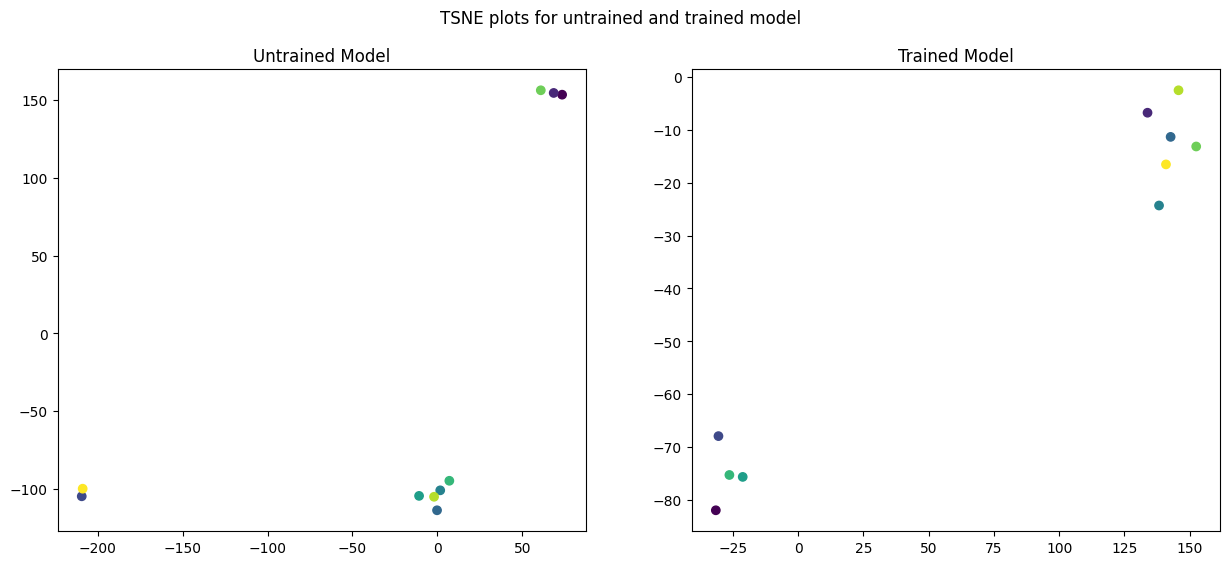

In [26]:
tsne_features_untrained = tsne.fit_transform(np.array(features_untrained).reshape(10, -1))
tsne_features_trained = tsne.fit_transform(np.array(features_trained).reshape(10, -1))

# Subplot for the untrained and trained model's features
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('TSNE plots for untrained and trained model')
ax[0].scatter(tsne_features_untrained[:, 0], tsne_features_untrained[:, 1], c=np.arange(10), cmap='viridis')
ax[0].set_title('Untrained Model')
ax[1].scatter(tsne_features_trained[:, 0], tsne_features_trained[:, 1], c=np.arange(10), cmap='viridis')
ax[1].set_title('Trained Model')
plt.savefig('./figures/tsne_mlp.pdf', bbox_inches='tight')
plt.show()

#### Plotting the t-SNE plot for the output of the second layer of the Trained MLP model for the MNIST and FashionMNIST dataset

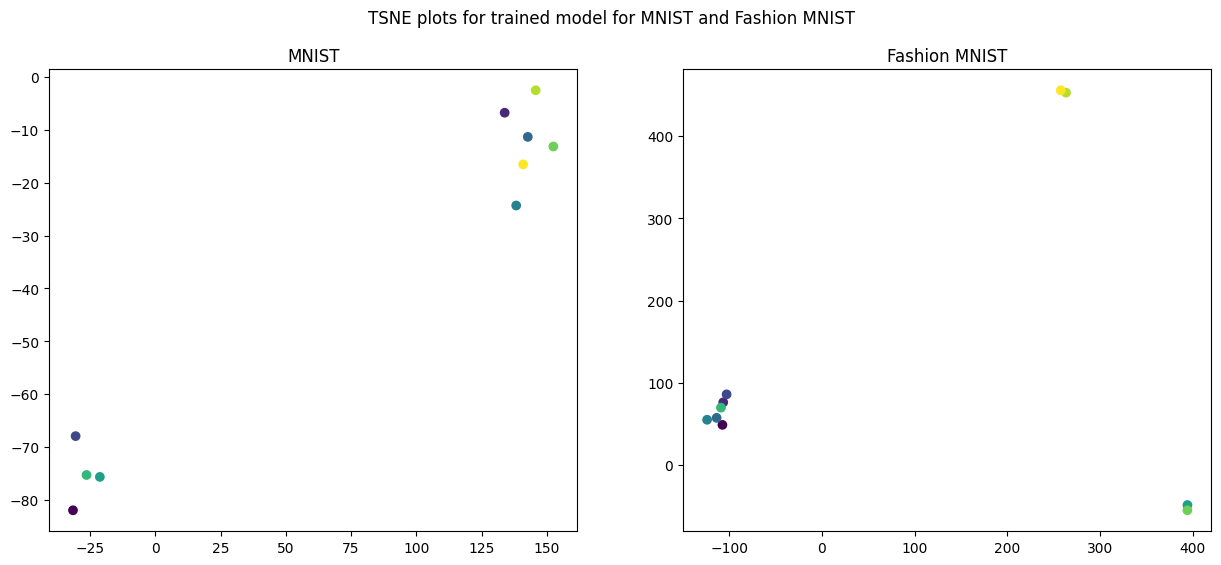

In [27]:
tsne_features_trained_fm = tsne.fit_transform(np.array(features_trained_fm).reshape(10, -1))

# Subplot for the trained model's features for MNIST and Fashion MNIST
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('TSNE plots for trained model for MNIST and Fashion MNIST')
ax[0].scatter(tsne_features_trained[:, 0], tsne_features_trained[:, 1], c=np.arange(10), cmap='viridis')
ax[0].set_title('MNIST')
ax[1].scatter(tsne_features_trained_fm[:, 0], tsne_features_trained_fm[:, 1], c=np.arange(10), cmap='viridis')
ax[1].set_title('Fashion MNIST')
plt.savefig('./figures/tsne_mlp_mnist_fm.pdf', bbox_inches='tight')
plt.show()